Both CGCNN and GP modeling were too good at making predictions on CatHub's validation set. We double-checked the splitting and don't see any obvious leakage into the training set. This notebook documents our journey into figuring this out.

# Homogeneity
First, make a function to calculate the lipschitz distribution of a dataset

In [1]:
import warnings
import itertools
import multiprocess
import numpy as np
import pandas as pd
import h5py
from tqdm import tqdm_notebook


def calculate_lipschitz(_docs, _features, suffix, force=False, processes=8):
    '''
    Calculates the Lipschitz values of a series of data.
    
    Args:
        _docs       A list of dictionaries of parsed information
        _features   A numpy array of features. Should map to `docs`
        suffix      A string indicating the suffix you want to use
                    for the cache of results that this function will use
        force       A Boolean indicating whether or not you want to force
                    this function to recalculate the Lipschitz values
                    (as opposed to just loading a cache).
        processes   An integeter indicating how many processes you want
                    to use whem multithreading
    Returns:
        lips    A pandas.Series of all the Lipschitz values for each
                combination of data points
    '''
    # If we're not forcing a re-do, then try to just load the data
    if force is False:
        try:
            with h5py.File('lips_%s.hdf5' % suffix, 'r') as h5_handle:
                lips = h5_handle['lips']
                lips = pd.Series(lips)
            return lips

        # If the file is not there, then move on to the rest of this code,
        # which will do the calculation
        except OSError:
            pass


    # Push these big objects to global space for faster process sharing
    global docs
    global features
    docs = _docs
    features = _features

    def __calculate_lipschitz(indices):
        '''
        Calculates the Lipschitz value between document with index i
        and document with index j, where indices=(i, j). We make a
        function so that we can multimap it.

        Args:
            indices 2-tuple contaning the indices of the documents you
                    want to get the Lipschitz value for
        Returns:
            lipschitz   The Lipschitz value between document i and j
        '''
        i, j = indices
        energy_diff = docs[i]['energy'] - docs[j]['energy']
        feature_diff = features[i, :] - features[j, :]
        lipschitz = abs(energy_diff) / np.linalg.norm(feature_diff, 2)
        return lipschitz

    # Figure out all the 2-pair combinations
    index_combinations = itertools.combinations(range(len(docs)), 2)
    n_docs = len(docs)
    n_combinations = int((n_docs * (n_docs-1))/2)

    # Ignore divide-by-zero warnings
    with warnings.catch_warnings(): 
        warnings.simplefilter('ignore', category=RuntimeWarning)
        # Multithreaded calculations
        with multiprocess.Pool(processes=processes, maxtasksperchild=1000) as pool:
            iterator = pool.imap(__calculate_lipschitz, index_combinations, chunksize=10000)
            lips = list(tqdm_notebook(iterator, total=n_combinations, unit_scale=True))

    # Filter out things with infinity
    lips = [lip for lip in lips if lip != np.inf]

    # Save the data
    with h5py.File('lips_%s.hdf5' % suffix, 'w') as h5_handle:
        h5_handle.create_dataset('lips', data=lips, dtype='f', compression='gzip')
        lips = pd.Series(lips)

    # Clean up and output
    del globals()['docs']
    del globals()['features']
    return lips

## CatHub
Maybe the CatHub data has a lot of duplicate or similar datapoints, while GASpy does not. Lets figure out the homogeneity of both datasets and compare them.

In [3]:
import pickle


# Load data
with open('../splits_cathub.pkl', 'rb') as file_handle:
    splits = pickle.load(file_handle)

# Parse data
docs_train = splits['docs_train']
docs_val = splits['docs_val']
fingerprints_train = splits['fingerprints_train']
fingerprints_val = splits['fingerprints_val']

In [26]:
# Calculate Lipschitz distribution
lips_val = calculate_lipschitz(docs_val, fingerprints_val, 'cathub_val')
lips_train = calculate_lipschitz(docs_train, fingerprints_train, 'cathub_train')

# We accidentally forgot to drop NaN values. Do so here.
lips_val = lips_val.dropna()
lips_train = lips_train.dropna()

# Report number of pairs
print('%i training pairs' % lips_train.shape[0])
print('%i validation pairs' % lips_val.shape[0])

226896705 training pairs
7989045 validation pairs


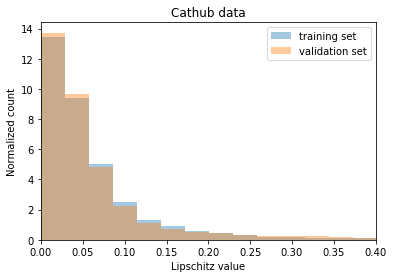

In [18]:
%matplotlib inline
import seaborn as sns


# Plot the distributions
ax = sns.distplot(lips_train, kde=False,
                  bins=1000,
                  norm_hist=True,
                  label='training set'
                 )
ax = sns.distplot(lips_val, kde=False,
                  bins=1000,
                  norm_hist=True,
                  label='validation set'
                 )

# Format
#plot_lims = (0, 0.4)
#_ = ax.set_xlim(plot_lims)
_ = ax.set_xlabel('Lipschitz value')
_ = ax.set_ylabel('Normalized count')
_ = ax.set_title('Cathub data')
_ = ax.legend()

## GASpy
Now let's look at our baseline

In [19]:
import pickle


# Load data
with open('../splits_gasdb.pkl', 'rb') as file_handle:
    splits = pickle.load(file_handle)

# Parse data
docs_train = splits['docs_train']
docs_val = splits['docs_val']
fingerprints_train = splits['fingerprints_train']
fingerprints_val = splits['fingerprints_val']

In [27]:
# Calculate Lipschitz distribution
lips_val = calculate_lipschitz(docs_val, fingerprints_val, 'gasdb_val')
lips_train = calculate_lipschitz(docs_train, fingerprints_train, 'gasdb_train')

# We accidentally forgot to drop NaN values. Do so here.
lips_val = lips_val.dropna()
lips_train = lips_train.dropna()

# Report number of pairs
print('%i training pairs' % lips_train.shape[0])
print('%i validation pairs' % lips_val.shape[0])

523465781 training pairs
21978904 validation pairs


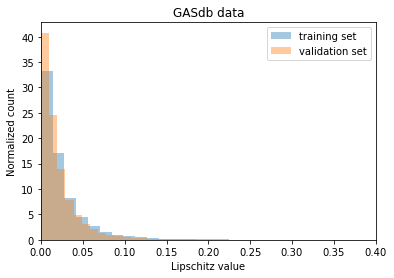

In [32]:
%matplotlib inline
import seaborn as sns


# Plot the distributions
ax = sns.distplot(lips_train, kde=False,
                  bins=1000,
                  norm_hist=True,
                  label='training set'
                 )
ax = sns.distplot(lips_val, kde=False,
                  bins=1000,
                  norm_hist=True,
                  label='validation set'
                 )

# Format
plot_lims = (0, 0.4)
_ = ax.set_xlim(plot_lims)
_ = ax.set_xlabel('Lipschitz value')
_ = ax.set_ylabel('Normalized count')
_ = ax.set_title('GASdb data')
_ = ax.legend()